In [139]:
# Import all Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

url = 'https://github.com/sehyunlee217/MIE368_proj/blob/main/watson_healthcare_modified.csv?raw=true'

In [140]:
# Read data
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# Apply one-hot encoding to nominal variables
cols_nom = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']

encoder = OneHotEncoder()

# Fit on training data
encoder.fit(train_df[cols_nom])

# Transform both training and test datasets
train_encoded = pd.DataFrame(encoder.transform(train_df[cols_nom]).toarray(),
                             columns=encoder.get_feature_names_out())
test_encoded = pd.DataFrame(encoder.transform(test_df[cols_nom]).toarray(),
                            columns=encoder.get_feature_names_out())

# Reset index and merge encoded columns back
train_encoded.reset_index(drop=True, inplace=True)
test_encoded.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df.drop(columns=cols_nom, inplace=True)
test_df.drop(columns=cols_nom, inplace=True)

train_df = pd.concat([train_df, train_encoded], axis=1)
test_df = pd.concat([test_df, test_encoded], axis=1)


In [141]:
# apply SMOTE on X_train
X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(len(X_train_resampled.columns))
print(len(X_test.columns))


42
42


In [142]:
# fitting Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG, display

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

print(len(X_train_resampled.columns))
print(len(X_test.columns))

# Define the hyperparameter distributions
param_dist = {
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 50)
}

# Initialize the CART model
CART = DecisionTreeClassifier()

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=CART,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    verbose=2,
    random_state=1,
    n_jobs=-1,
    return_train_score=True,
)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Extract the best score and the best hyperparameters
best_score_dt = random_search.best_score_
best_params = random_search.best_params_

# Print the best score and hyperparameters
print(f"Best performance using decision tree is {best_score_dt:.9f} with a max depth of {best_params['max_depth']} and a min samples split of {best_params['min_samples_split']}")

42
42
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.1s
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.1s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.1s
[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.1s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.1s[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.1s

[CV] END ..................max_depth=6, min_samples_split=45; total time=   0.1s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=17; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=11; total time=   0.0s
[CV] END ..................max_depth=6,

In [149]:
from sklearn.metrics import precision_recall_fscore_support as prfs, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

print(len(X_train_resampled.columns))
print(len(X_test.columns))

# Define the calculate_metrics function
def calculate_metrics(X_test, y_test, model):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate precision, recall, f1-score, and support
    metrics_values = prfs(y_test, y_pred)
    
    # Extract recall and f1-score for the positive class (class 1)
    recall = metrics_values[1][1]
    f1 = metrics_values[2][1]

    return recall, f1

# Define the plot_ROC function
def plot_ROC(model, X_test, y_test, estimator_name='Model'):
    # Get predicted probabilities for the positive class
    pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=estimator_name)

    # Plot ROC curve
    display

    return display

# Example usage
best_CART = random_search.best_estimator_


42
42


In [153]:
from sklearn.metrics import precision_recall_fscore_support as metrics
# Get the best estimator
best_CART= random_search.best_estimator_
recall_cart, f1_cart = calculate_metrics(X_test, y_test, best_CART)

display_cart = plot_ROC(best_CART, X_test, y_test, "CART")

In [154]:
#  SVM
# Import classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define the SVM instance
svm = SVC(probability=True)

# Run Grid Search with parameters to find most optimial combination of parameters

# Pipeline with scaling and SVM
pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Define hyperparameter grid
param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto', 0.1, 1]}

# GridSearch for best parameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_resampled, y_train_resampled)
svm = grid.best_estimator_

recall_svm, f1_svm = calculate_metrics(X_test, y_test, svm)
display_svm = plot_ROC(svm, X_test, y_test, "SVM")

In [ ]:

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd

print(len(X_train_resampled.columns))
print(len(X_test.columns))

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

bagging_param_grid = {
    'n_estimators': [50, 100, 200],
    'estimator__max_depth': [3, 5, 7, 10],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}


rf_model = RandomForestClassifier(random_state=42)
bagging_base = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),random_state=42)

rf_grid_search = GridSearchCV(estimator=rf_model,param_grid=rf_param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

rf_model = rf_grid_search.best_estimator_

bagging_grid_search = GridSearchCV(estimator=bagging_base,param_grid=bagging_param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)
bagging_grid_search.fit(X_train_resampled, y_train_resampled)

bagging_model = bagging_grid_search.best_estimator_

42
42
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


(0.425531914893617, 0.5128205128205128)
(0.3829787234042553, 0.5)


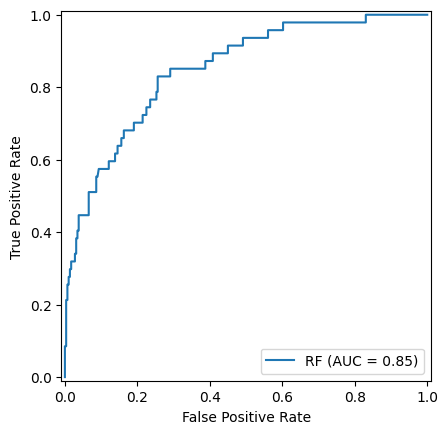

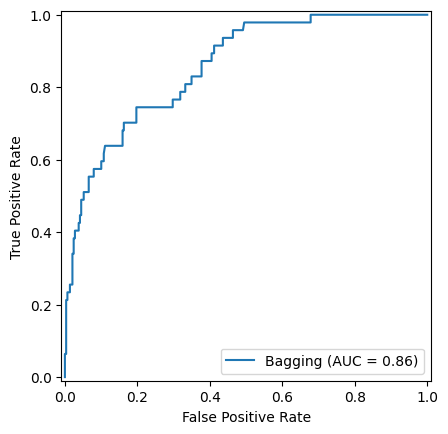

In [ ]:
print(calculate_metrics(X_test, y_test, rf_model))
plot_ROC(rf_model, X_test, y_test, "RF")

print(calculate_metrics(X_test, y_test, bagging_model))
plot_ROC(bagging_model, X_test, y_test, "Bagging")

(0.5319148936170213, 0.6097560975609756)


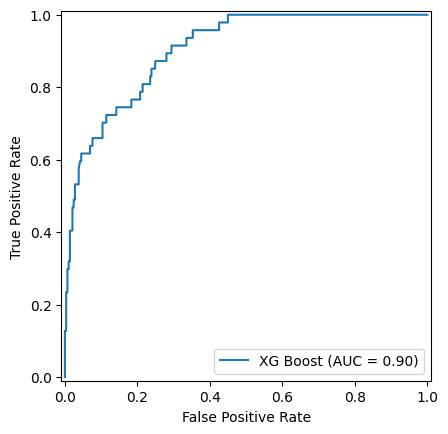

In [ ]:
import xgboost as x
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb = x.XGBClassifier()
xgb.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
print(calculate_metrics(X_test, y_test, xgb))
plot_ROC(xgb, X_test, y_test, "XG Boost")


In [160]:
%pip install catboost
%pip install optuna
import catboost
from catboost import CatBoostClassifier, Pool

# Catboost works better without one-hot encoding
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# apply SMOTE on X_train
X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=True
              )

cat_train_pool = catboost.Pool(X_train_, y_train, cat_features=categorical_features)
cat_test_pool = catboost.Pool(X_test, y_test, cat_features=categorical_features)


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
0:	learn: 0.3201537	total: 1.7ms	remaining: 169ms
1:	learn: 0.2578593	total: 2.96ms	remaining: 145ms
2:	learn: 0.2410384	total: 4.07ms	remaining: 131ms
3:	learn: 0.2270980	total: 5.11ms	remaining: 123ms
4:	learn: 0.2080941	total: 5.98ms	remaining: 114ms
5:	learn: 0.1873131	total: 7.11ms	remaining: 111ms
6:	learn: 0.1703477	total: 7.92ms	remaining: 105ms
7:	learn: 0.1604228	total: 8.88ms	remaining: 102ms
8:	learn: 0.1530673	total: 10ms	remaining: 101ms
9:	learn: 0.1492079	total: 11ms	remaining: 98.6ms
10:	learn: 0.1491936	total: 11.8ms	remaining: 95.4ms
11:	learn: 0.1441654	total: 13.4ms	remaining: 98.5ms
12:	learn: 0.1366099	total: 14.4ms

NameError: name 'X_train_' is not defined

In [ ]:
import catboost
from catboost.utils import eval_metric
import optuna
from optuna.samplers import TPESampler

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=0
              )


preds_class = cat_model.predict(X_test)
preds_proba = cat_model.predict_proba(y_test)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'depth': trial.suggest_int('depth', 1, 6),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
    }

    model = catboost.CatBoostClassifier(**params, random_seed=42)
    model.fit(cat_train_pool, verbose=False)
    y_pred = model.predict(cat_test_pool)
    return accuracy_score(y_pred, y_test)

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2024-11-22 12:24:18,039] A new study created in memory with name: no-name-87af4476-0d0f-4c91-8b82-cfcb544d4d63
[I 2024-11-22 12:24:18,910] Trial 0 finished with value: 0.9285714285714286 and parameters: {'learning_rate': 0.7268222670380755, 'depth': 2, 'boosting_type': 'Plain', 'max_ctr_complexity': 6}. Best is trial 0 with value: 0.9285714285714286.
[I 2024-11-22 12:24:22,696] Trial 1 finished with value: 0.9136904761904762 and parameters: {'learning_rate': 0.4807958141120149, 'depth': 6, 'boosting_type': 'Ordered', 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.9285714285714286.
[I 2024-11-22 12:24:25,129] Trial 2 finished with value: 0.9166666666666666 and parameters: {'learning_rate': 0.4088602145357825, 'depth': 5, 'boosting_type': 'Ordered', 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.9285714285714286.
[I 2024-11-22 12:24:26,023] Trial 3 finished with value: 0.9226190476190477 and parameters: {'learning_rate': 0.7641958651588321, 'depth': 2, 'boosting_type

In [161]:
print(len(X_train_resampled.columns))
print(len(X_test.columns))

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=1, learning_rate=0.7111094911557769, boosting_type='Plain', max_ctr_complexity=8)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=0
              )


preds_class = cat_model.predict(X_test)
preds_proba = cat_model.predict_proba(y_test)

print(calculate_metrics(X_test, y_test, cat_model))
plot_ROC(cat_model, X_test, y_test, "CAT-Boost")

42
29
(0.574468085106383, 0.7012987012987013)


In [ ]:
%pip install catboost
%pip install optuna
import catboost
from catboost import CatBoostClassifier, Pool

# Catboost works better without one-hot encoding
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# apply SMOTE on X_train
X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=True
              )

cat_train_pool = catboost.Pool(X_train, y_train, cat_features=categorical_features)
cat_test_pool = catboost.Pool(X_test, y_test, cat_features=categorical_features)

import catboost
from catboost.utils import eval_metric
import optuna
from optuna.samplers import TPESampler

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='Logloss', verbose=True)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=0
              )


preds_class = cat_model.predict(X_test)
preds_proba = cat_model.predict_proba(y_test)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'depth': trial.suggest_int('depth', 1, 6),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8)
    }

    model = catboost.CatBoostClassifier(**params, random_seed=42)
    model.fit(cat_train_pool, verbose=False)
    y_pred = model.predict(cat_test_pool)
    return accuracy_score(y_pred, y_test)

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=20)

print(len(X_train_resampled.columns))
print(len(X_test.columns))

categorical_features = ['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'Gender', 'OverTime', 'BusinessTravel']

cat_model = CatBoostClassifier(iterations=100, depth=1, learning_rate=0.7111094911557769, boosting_type='Plain', max_ctr_complexity=8)

cat_model.fit(X_train, 
              y_train,
              cat_features=categorical_features,
              verbose=0
              )


preds_class = cat_model.predict(X_test)
preds_proba = cat_model.predict_proba(y_test)

print(calculate_metrics(X_test, y_test, cat_model))
plot_ROC(cat_model, X_test, y_test, "CAT-Boost")

In [163]:
from sklearn.metrics import precision_recall_fscore_support as prfs

def calculate_metrics(X_test, y_test, model):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate precision, recall, f1-score, and support
    metrics_values = prfs(y_test, y_pred)
    
    # Extract recall and f1-score for the positive class (class 1)
    recall = metrics_values[1][1]
    f1 = metrics_values[2][1]

    return recall, f1

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Load data
df = pd.read_csv(url)

# Drop unnecessary columns
df.drop(columns=['EmployeeID', 'EmployeeCount', 'Shift', 'StandardHours', 'Over18'], inplace=True)

# Split data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Map target variable in training and testing data
train_df['Attrition'] = train_df['Attrition'].map({"Yes": 1, "No": 0})
test_df['Attrition'] = test_df['Attrition'].map({"Yes": 1, "No": 0})

# Convert categorical to numerical for both datasets
train_df['Gender'] = train_df['Gender'].map({'Male': 0, 'Female': 1})
train_df['OverTime'] = train_df['OverTime'].map({'No': 0, 'Yes': 1})
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

test_df['Gender'] = test_df['Gender'].map({'Male': 0, 'Female': 1})
test_df['OverTime'] = test_df['OverTime'].map({'No': 0, 'Yes': 1})
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(
    {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
)

# One-hot encode categorical features
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

# Align the columns of the test set with the training set
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Split features and target
X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']
X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 4 should be feature with name DistanceFromHome (found Education).

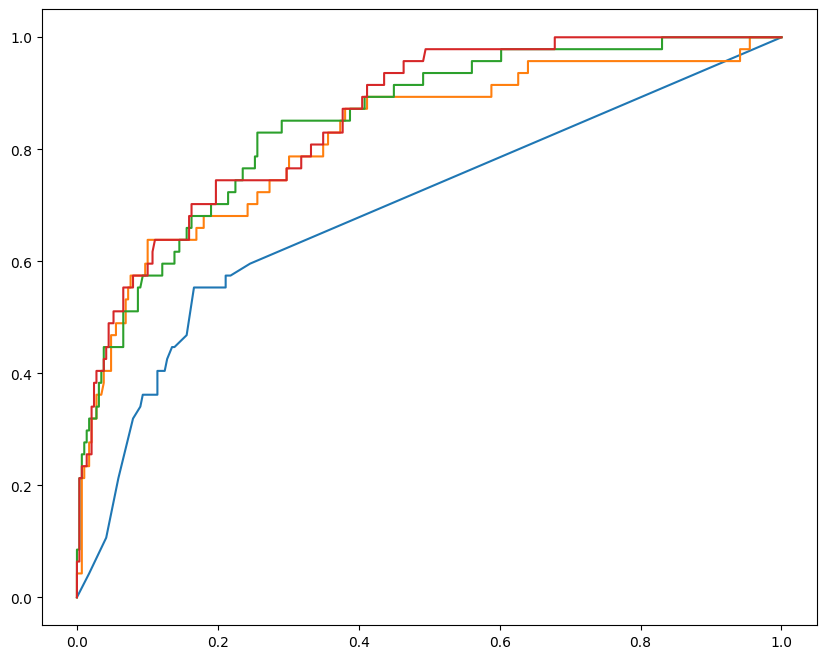

In [165]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

def plot_combined_ROC(models, X_test, y_test, labels):
    plt.figure(figsize=(10, 8))
    
    for model, label in zip(models, labels):
        # Get predicted probabilities for the positive class
        pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
models = [best_CART, svm, rf_model, bagging_model, cat_model]
labels = ['CART', 'SVM', 'Random Forest', 'Bagged Trees', 'CatBoost']
plot_combined_ROC(models, X_test, y_test, labels)